# VGG8B - CIFAR-10

In [1]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_CNN, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [4]:
architecture = [
    ('Conv2d', 128, 3, 1, 1),
    ('Conv2d', 256, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 256, 3, 1, 1),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
    ('Conv2d', 512, 3, 1, 1),
    ('MaxPool2d', 2, 2),
]
num_fc_layers = 2
num_fc_hidden = [1024]

In [5]:
dataset_config = dict(
    dataset=Dataset.CIFAR10.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=True,
    normalize=True,
)

In [6]:
network_config = dict(
    architecture=architecture,
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    pred_decoder_dim=4096,
    fe_dropout_rate=0.0,
    fc_dropout_rate=0.15,
    seed=42,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    pooling_type='max',
    bias=False,
    debug=False,
)

In [7]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=25_000,
    subnet_decay_inv=3000,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [8]:
config = dataset_config | network_config | training_config

## Run the configuration

Files already downloaded and verified


Files already downloaded and verified


Training on 50000 samples


Data normalized. New statistics:
-  Min: [-123 -123 -104]
-  Max: [126 127 127]
- Mean: [0 0 0]
-  Std: [61 62 60]



Moved data to device: <CUDA Device 0>
Train set:  (50000, 3, 32, 32), (50000, 10)
Test set:   (10000, 3, 32, 32), (10000, 10)
Data types: (int8, int8)


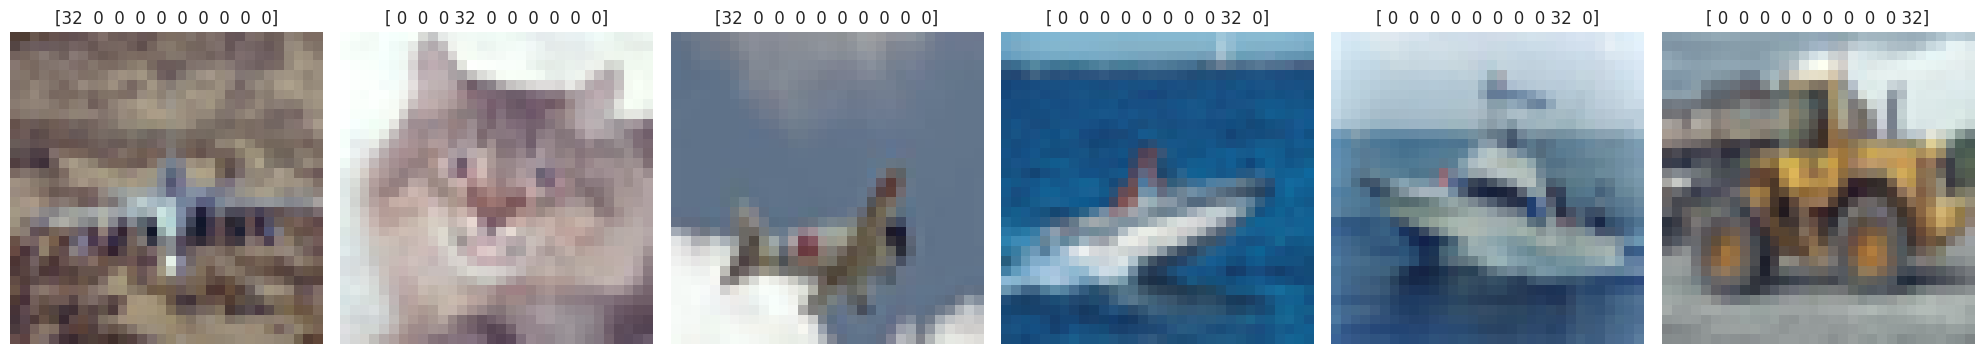

In [9]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [10]:
model = build_CNN(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossCNN(
	(0): Sequential(
			(0): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=3, out_channels=128, bias=False, decay_rate_inv=25000)
			(1): ConstantScaling(fwd_factor=6912, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(8, 4), stride=(8, 4), padding=(0, 0))
			(1): Flatten()
			(2): IntegerLinear(in_features=4096, out_features=10, bias=False, decay_rate_inv=3000)
			(3): ConstantScaling(fwd_factor=1048576, bwd_factor=1)
		)
	)
			(1): LocalConv2dBlock(
			(0): IntegerConv2d(in_channels=128, out_channels=256, bias=False, decay_rate_inv=25000)
			(1): ConstantScaling(fwd_factor=294912, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): MaxPool2d(kernel_size=(8, 8), stride=(8, 8), padding=(0, 0))
			(1): Flatten()
			(2): IntegerLinear(in_features=4096, out_features=10, bias=False, decay_rate_inv=3000)
			(3): ConstantScaling(fwd_factor=10485

In [11]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)

    # Build and train the model
    m = build_CNN(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])
        
    # Save the first model
    if not pathlib.Path('model.pkl').exists():
        with open('model.pkl', 'wb') as f:
            pickle.dump(m, f)

In [12]:
N_EXPERIMENTS = 10
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 42...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.869% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 19.352% - Test accuracy: 29.677%


Epoch   3/150 - Train accuracy: 34.819% - Test accuracy: 44.842%


Epoch   4/150 - Train accuracy: 46.207% - Test accuracy: 51.162%


Epoch   5/150 - Train accuracy: 52.037% - Test accuracy: 55.829%


Epoch   6/150 - Train accuracy: 56.852% - Test accuracy: 62.440%


Epoch   7/150 - Train accuracy: 60.731% - Test accuracy: 59.846%


Epoch   8/150 - Train accuracy: 63.100% - Test accuracy: 66.657%


Epoch   9/150 - Train accuracy: 65.545% - Test accuracy: 67.107%


Epoch  10/150 - Train accuracy: 67.171% - Test accuracy: 70.563%


Epoch  11/150 - Train accuracy: 68.746% - Test accuracy: 70.302%


Epoch  12/150 - Train accuracy: 70.367% - Test accuracy: 71.024%


Epoch  13/150 - Train accuracy: 71.047% - Test accuracy: 73.658%


Epoch  14/150 - Train accuracy: 72.141% - Test accuracy: 75.942%


Epoch  15/150 - Train accuracy: 73.153% - Test accuracy: 74.990%


Epoch  16/150 - Train accuracy: 73.764% - Test accuracy: 75.260%


Epoch  17/150 - Train accuracy: 74.590% - Test accuracy: 70.773%


Epoch  18/150 - Train accuracy: 74.986% - Test accuracy: 74.810%


Epoch  19/150 - Train accuracy: 75.874% - Test accuracy: 76.733%


Epoch  20/150 - Train accuracy: 76.072% - Test accuracy: 76.933%


Epoch  21/150 - Train accuracy: 76.711% - Test accuracy: 75.260%


Epoch  22/150 - Train accuracy: 76.905% - Test accuracy: 77.043%


Epoch  23/150 - Train accuracy: 77.881% - Test accuracy: 78.766%


Epoch  24/150 - Train accuracy: 78.223% - Test accuracy: 78.155%


Epoch  25/150 - Train accuracy: 78.441% - Test accuracy: 76.773%


Epoch  26/150 - Train accuracy: 78.641% - Test accuracy: 80.218%


Epoch  27/150 - Train accuracy: 79.139% - Test accuracy: 77.394%


Epoch  28/150 - Train accuracy: 79.814% - Test accuracy: 78.295%


Epoch  29/150 - Train accuracy: 79.834% - Test accuracy: 78.726%


Epoch  30/150 - Train accuracy: 80.168% - Test accuracy: 79.908%


Epoch  31/150 - Train accuracy: 80.396% - Test accuracy: 79.046%


Epoch  32/150 - Train accuracy: 80.846% - Test accuracy: 80.739%


Epoch  33/150 - Train accuracy: 80.964% - Test accuracy: 80.158%


Epoch  34/150 - Train accuracy: 81.070% - Test accuracy: 79.277%


Epoch  35/150 - Train accuracy: 81.438% - Test accuracy: 81.150%


Epoch  36/150 - Train accuracy: 81.498% - Test accuracy: 78.405%


Epoch  37/150 - Train accuracy: 81.740% - Test accuracy: 79.948%


Epoch  38/150 - Train accuracy: 82.216% - Test accuracy: 81.070%


Epoch  39/150 - Train accuracy: 82.374% - Test accuracy: 80.789%


Epoch  40/150 - Train accuracy: 82.682% - Test accuracy: 82.672%


Epoch  41/150 - Train accuracy: 82.957% - Test accuracy: 80.839%


Epoch  42/150 - Train accuracy: 82.925% - Test accuracy: 81.380%


Epoch  43/150 - Train accuracy: 83.321% - Test accuracy: 81.430%


Epoch  44/150 - Train accuracy: 83.227% - Test accuracy: 81.190%


Epoch  45/150 - Train accuracy: 83.457% - Test accuracy: 79.778%


Epoch  46/150 - Train accuracy: 83.317% - Test accuracy: 81.530%


Epoch  47/150 - Train accuracy: 83.353% - Test accuracy: 80.529%


Epoch  48/150 - Train accuracy: 83.571% - Test accuracy: 81.911%


Epoch  49/150 - Train accuracy: 83.643% - Test accuracy: 80.519%


Epoch  50/150 - Train accuracy: 84.023% - Test accuracy: 82.322%


Epoch  51/150 - Train accuracy: 83.991% - Test accuracy: 82.322%


Epoch  52/150 - Train accuracy: 84.241% - Test accuracy: 81.130%


Epoch  53/150 - Train accuracy: 84.243% - Test accuracy: 83.123%


Epoch  54/150 - Train accuracy: 84.189% - Test accuracy: 82.732%


Epoch  55/150 - Train accuracy: 84.601% - Test accuracy: 81.170%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 55
----------------------------------------------------------------


Epoch  56/150 - Train accuracy: 88.548% - Test accuracy: 85.647%


Epoch  57/150 - Train accuracy: 89.052% - Test accuracy: 85.407%


Epoch  58/150 - Train accuracy: 89.185% - Test accuracy: 85.517%


Epoch  59/150 - Train accuracy: 89.443% - Test accuracy: 85.777%


Epoch  60/150 - Train accuracy: 89.645% - Test accuracy: 86.158%


Epoch  61/150 - Train accuracy: 89.741% - Test accuracy: 85.697%


Epoch  62/150 - Train accuracy: 89.857% - Test accuracy: 86.278%


Epoch  63/150 - Train accuracy: 89.963% - Test accuracy: 85.687%


Epoch  64/150 - Train accuracy: 90.031% - Test accuracy: 86.198%


Epoch  65/150 - Train accuracy: 90.229% - Test accuracy: 85.817%


Epoch  66/150 - Train accuracy: 90.109% - Test accuracy: 85.767%


Epoch  67/150 - Train accuracy: 90.365% - Test accuracy: 86.248%


Epoch  68/150 - Train accuracy: 90.415% - Test accuracy: 85.907%


Epoch  69/150 - Train accuracy: 90.459% - Test accuracy: 86.398%


Epoch  70/150 - Train accuracy: 90.633% - Test accuracy: 85.587%


Epoch  71/150 - Train accuracy: 90.527% - Test accuracy: 86.368%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 71
----------------------------------------------------------------


Epoch  72/150 - Train accuracy: 91.575% - Test accuracy: 86.959%


Epoch  73/150 - Train accuracy: 91.799% - Test accuracy: 87.029%


Epoch  74/150 - Train accuracy: 91.787% - Test accuracy: 87.099%


Epoch  75/150 - Train accuracy: 92.125% - Test accuracy: 87.480%


Epoch  76/150 - Train accuracy: 92.025% - Test accuracy: 87.220%


Epoch  77/150 - Train accuracy: 92.027% - Test accuracy: 86.949%


Epoch  78/150 - Train accuracy: 91.767% - Test accuracy: 86.959%


Epoch  79/150 - Train accuracy: 92.141% - Test accuracy: 87.310%


Epoch  80/150 - Train accuracy: 92.097% - Test accuracy: 86.899%


Epoch  81/150 - Train accuracy: 92.073% - Test accuracy: 87.560%


Epoch  82/150 - Train accuracy: 92.139% - Test accuracy: 87.410%


Epoch  83/150 - Train accuracy: 92.135% - Test accuracy: 87.400%


Epoch  84/150 - Train accuracy: 92.107% - Test accuracy: 87.290%


Epoch  85/150 - Train accuracy: 92.137% - Test accuracy: 87.340%


Epoch  86/150 - Train accuracy: 92.240% - Test accuracy: 87.450%


Epoch  87/150 - Train accuracy: 92.179% - Test accuracy: 87.310%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 87
----------------------------------------------------------------


Epoch  88/150 - Train accuracy: 92.412% - Test accuracy: 87.700%


Epoch  89/150 - Train accuracy: 92.728% - Test accuracy: 87.530%


Epoch  90/150 - Train accuracy: 92.398% - Test accuracy: 87.700%


Epoch  91/150 - Train accuracy: 92.474% - Test accuracy: 87.590%


Epoch  92/150 - Train accuracy: 92.680% - Test accuracy: 87.640%


Epoch  93/150 - Train accuracy: 92.676% - Test accuracy: 87.350%


Epoch  94/150 - Train accuracy: 92.524% - Test accuracy: 87.760%


Epoch  95/150 - Train accuracy: 92.634% - Test accuracy: 87.430%


Epoch  96/150 - Train accuracy: 92.664% - Test accuracy: 87.690%


Epoch  97/150 - Train accuracy: 92.788% - Test accuracy: 87.570%


Epoch  98/150 - Train accuracy: 92.504% - Test accuracy: 87.620%


Epoch  99/150 - Train accuracy: 92.480% - Test accuracy: 87.430%


Epoch 100/150 - Train accuracy: 92.594% - Test accuracy: 87.630%


Epoch 101/150 - Train accuracy: 92.592% - Test accuracy: 87.690%


Epoch 102/150 - Train accuracy: 92.916% - Test accuracy: 87.450%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 102
----------------------------------------------------------------


Epoch 103/150 - Train accuracy: 92.916% - Test accuracy: 87.740%


Epoch 104/150 - Train accuracy: 92.766% - Test accuracy: 87.590%


Epoch 105/150 - Train accuracy: 92.782% - Test accuracy: 87.660%


Epoch 106/150 - Train accuracy: 92.912% - Test accuracy: 87.670%


Epoch 107/150 - Train accuracy: 92.688% - Test accuracy: 87.690%
----------------------------------------------------------------
Early stopping at epoch 107
----------------------------------------------------------------


----------------------------------------------------------------
Running experiment with seed 43...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.189% - Test accuracy: 10.016%


Epoch   2/150 - Train accuracy: 19.380% - Test accuracy: 28.205%


Epoch   3/150 - Train accuracy: 35.515% - Test accuracy: 45.944%


Epoch   4/150 - Train accuracy: 46.401% - Test accuracy: 52.464%


Epoch   5/150 - Train accuracy: 52.627% - Test accuracy: 57.402%


Epoch   6/150 - Train accuracy: 57.977% - Test accuracy: 59.796%


Epoch   7/150 - Train accuracy: 60.925% - Test accuracy: 64.373%


Epoch   8/150 - Train accuracy: 63.718% - Test accuracy: 58.363%


Epoch   9/150 - Train accuracy: 65.577% - Test accuracy: 68.520%


Epoch  10/150 - Train accuracy: 66.969% - Test accuracy: 70.553%


Epoch  11/150 - Train accuracy: 68.372% - Test accuracy: 71.424%


Epoch  12/150 - Train accuracy: 69.822% - Test accuracy: 71.314%


Epoch  13/150 - Train accuracy: 71.137% - Test accuracy: 73.798%


Epoch  14/150 - Train accuracy: 72.151% - Test accuracy: 72.145%


Epoch  15/150 - Train accuracy: 72.909% - Test accuracy: 75.280%


Epoch  16/150 - Train accuracy: 73.740% - Test accuracy: 72.476%


Epoch  17/150 - Train accuracy: 74.330% - Test accuracy: 76.082%


Epoch  18/150 - Train accuracy: 75.218% - Test accuracy: 75.200%


Epoch  19/150 - Train accuracy: 75.476% - Test accuracy: 75.471%


Epoch  20/150 - Train accuracy: 76.394% - Test accuracy: 74.479%


Epoch  21/150 - Train accuracy: 76.677% - Test accuracy: 76.883%


Epoch  22/150 - Train accuracy: 77.223% - Test accuracy: 78.365%


Epoch  23/150 - Train accuracy: 77.667% - Test accuracy: 76.723%


Epoch  24/150 - Train accuracy: 78.261% - Test accuracy: 78.245%


Epoch  25/150 - Train accuracy: 78.275% - Test accuracy: 79.357%


Epoch  26/150 - Train accuracy: 78.909% - Test accuracy: 78.355%


Epoch  27/150 - Train accuracy: 79.443% - Test accuracy: 79.617%


Epoch  28/150 - Train accuracy: 80.012% - Test accuracy: 79.297%


Epoch  29/150 - Train accuracy: 79.860% - Test accuracy: 79.117%


Epoch  30/150 - Train accuracy: 80.000% - Test accuracy: 80.759%


Epoch  31/150 - Train accuracy: 80.508% - Test accuracy: 81.130%


Epoch  32/150 - Train accuracy: 80.900% - Test accuracy: 80.158%


Epoch  33/150 - Train accuracy: 81.056% - Test accuracy: 79.978%


Epoch  34/150 - Train accuracy: 81.220% - Test accuracy: 82.101%


Epoch  35/150 - Train accuracy: 81.406% - Test accuracy: 80.899%


Epoch  36/150 - Train accuracy: 81.714% - Test accuracy: 81.270%


Epoch  37/150 - Train accuracy: 81.982% - Test accuracy: 79.728%


Epoch  38/150 - Train accuracy: 81.996% - Test accuracy: 79.988%


Epoch  39/150 - Train accuracy: 82.748% - Test accuracy: 81.030%


Epoch  40/150 - Train accuracy: 82.404% - Test accuracy: 81.260%


Epoch  41/150 - Train accuracy: 82.728% - Test accuracy: 80.789%


Epoch  42/150 - Train accuracy: 82.526% - Test accuracy: 81.480%


Epoch  43/150 - Train accuracy: 83.301% - Test accuracy: 79.918%


Epoch  44/150 - Train accuracy: 83.153% - Test accuracy: 80.679%


Epoch  45/150 - Train accuracy: 83.195% - Test accuracy: 82.011%


Epoch  46/150 - Train accuracy: 83.659% - Test accuracy: 82.422%


Epoch  47/150 - Train accuracy: 83.451% - Test accuracy: 81.230%


Epoch  48/150 - Train accuracy: 83.937% - Test accuracy: 81.490%


Epoch  49/150 - Train accuracy: 83.701% - Test accuracy: 83.053%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 49
----------------------------------------------------------------


Epoch  50/150 - Train accuracy: 87.600% - Test accuracy: 85.467%


Epoch  51/150 - Train accuracy: 88.410% - Test accuracy: 85.266%


Epoch  52/150 - Train accuracy: 88.558% - Test accuracy: 85.627%


Epoch  53/150 - Train accuracy: 88.704% - Test accuracy: 85.917%


Epoch  54/150 - Train accuracy: 89.087% - Test accuracy: 85.948%


Epoch  55/150 - Train accuracy: 89.121% - Test accuracy: 85.006%


Epoch  56/150 - Train accuracy: 89.381% - Test accuracy: 85.907%


Epoch  57/150 - Train accuracy: 89.287% - Test accuracy: 85.547%


Epoch  58/150 - Train accuracy: 89.681% - Test accuracy: 85.938%


Epoch  59/150 - Train accuracy: 89.219% - Test accuracy: 86.018%


Epoch  60/150 - Train accuracy: 89.685% - Test accuracy: 86.288%


Epoch  61/150 - Train accuracy: 89.829% - Test accuracy: 86.198%


Epoch  62/150 - Train accuracy: 90.025% - Test accuracy: 86.408%


Epoch  63/150 - Train accuracy: 89.771% - Test accuracy: 85.437%


Epoch  64/150 - Train accuracy: 90.105% - Test accuracy: 85.938%


Epoch  65/150 - Train accuracy: 90.057% - Test accuracy: 85.567%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 65
----------------------------------------------------------------


Epoch  66/150 - Train accuracy: 91.223% - Test accuracy: 87.310%


Epoch  67/150 - Train accuracy: 91.465% - Test accuracy: 87.079%


Epoch  68/150 - Train accuracy: 91.293% - Test accuracy: 87.440%


Epoch  69/150 - Train accuracy: 91.459% - Test accuracy: 87.430%


Epoch  70/150 - Train accuracy: 91.395% - Test accuracy: 87.169%


Epoch  71/150 - Train accuracy: 91.447% - Test accuracy: 87.149%


Epoch  72/150 - Train accuracy: 91.445% - Test accuracy: 87.390%


Epoch  73/150 - Train accuracy: 91.625% - Test accuracy: 87.270%


Epoch  74/150 - Train accuracy: 91.499% - Test accuracy: 87.099%


Epoch  75/150 - Train accuracy: 91.717% - Test accuracy: 87.580%


Epoch  76/150 - Train accuracy: 91.609% - Test accuracy: 87.310%


Epoch  77/150 - Train accuracy: 91.921% - Test accuracy: 87.530%


Epoch  78/150 - Train accuracy: 91.683% - Test accuracy: 86.368%


Epoch  79/150 - Train accuracy: 91.703% - Test accuracy: 87.089%


Epoch  80/150 - Train accuracy: 91.753% - Test accuracy: 87.280%


Epoch  81/150 - Train accuracy: 91.825% - Test accuracy: 87.500%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 81
----------------------------------------------------------------


Epoch  82/150 - Train accuracy: 92.121% - Test accuracy: 87.550%


Epoch  83/150 - Train accuracy: 92.216% - Test accuracy: 87.610%


Epoch  84/150 - Train accuracy: 92.214% - Test accuracy: 87.570%


Epoch  85/150 - Train accuracy: 92.312% - Test accuracy: 87.690%


Epoch  86/150 - Train accuracy: 92.099% - Test accuracy: 87.390%


Epoch  87/150 - Train accuracy: 92.286% - Test accuracy: 87.670%


Epoch  88/150 - Train accuracy: 92.268% - Test accuracy: 87.780%


Epoch  89/150 - Train accuracy: 92.400% - Test accuracy: 87.720%


Epoch  90/150 - Train accuracy: 92.260% - Test accuracy: 87.680%


Epoch  91/150 - Train accuracy: 91.977% - Test accuracy: 87.520%


Epoch  92/150 - Train accuracy: 92.364% - Test accuracy: 87.550%


Epoch  93/150 - Train accuracy: 92.316% - Test accuracy: 87.790%


Epoch  94/150 - Train accuracy: 92.332% - Test accuracy: 87.760%


Epoch  95/150 - Train accuracy: 92.240% - Test accuracy: 87.700%


Epoch  96/150 - Train accuracy: 92.454% - Test accuracy: 87.670%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 96
----------------------------------------------------------------


Epoch  97/150 - Train accuracy: 92.418% - Test accuracy: 87.720%


Epoch  98/150 - Train accuracy: 92.466% - Test accuracy: 87.730%


Epoch  99/150 - Train accuracy: 92.388% - Test accuracy: 87.650%


Epoch 100/150 - Train accuracy: 92.566% - Test accuracy: 87.670%


Epoch 101/150 - Train accuracy: 92.398% - Test accuracy: 87.590%
----------------------------------------------------------------
Early stopping at epoch 101
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 44...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.245% - Test accuracy: 09.996%


Epoch   2/150 - Train accuracy: 20.739% - Test accuracy: 27.764%


Epoch   3/150 - Train accuracy: 35.043% - Test accuracy: 41.376%


Epoch   4/150 - Train accuracy: 45.971% - Test accuracy: 47.606%


Epoch   5/150 - Train accuracy: 51.246% - Test accuracy: 56.220%


Epoch   6/150 - Train accuracy: 56.148% - Test accuracy: 55.659%


Epoch   7/150 - Train accuracy: 60.321% - Test accuracy: 52.714%


Epoch   8/150 - Train accuracy: 62.994% - Test accuracy: 66.887%


Epoch   9/150 - Train accuracy: 65.011% - Test accuracy: 65.775%


Epoch  10/150 - Train accuracy: 67.093% - Test accuracy: 69.692%


Epoch  11/150 - Train accuracy: 68.398% - Test accuracy: 70.493%


Epoch  12/150 - Train accuracy: 69.554% - Test accuracy: 71.054%


Epoch  13/150 - Train accuracy: 70.657% - Test accuracy: 72.286%


Epoch  14/150 - Train accuracy: 72.481% - Test accuracy: 74.509%


Epoch  15/150 - Train accuracy: 72.557% - Test accuracy: 73.708%


Epoch  16/150 - Train accuracy: 73.401% - Test accuracy: 73.898%


Epoch  17/150 - Train accuracy: 74.124% - Test accuracy: 74.539%


Epoch  18/150 - Train accuracy: 75.114% - Test accuracy: 72.336%


Epoch  19/150 - Train accuracy: 75.448% - Test accuracy: 74.760%


Epoch  20/150 - Train accuracy: 75.998% - Test accuracy: 74.389%


Epoch  21/150 - Train accuracy: 76.412% - Test accuracy: 76.132%


Epoch  22/150 - Train accuracy: 76.631% - Test accuracy: 78.315%


Epoch  23/150 - Train accuracy: 77.437% - Test accuracy: 77.634%


Epoch  24/150 - Train accuracy: 77.931% - Test accuracy: 76.212%


Epoch  25/150 - Train accuracy: 78.195% - Test accuracy: 76.412%


Epoch  26/150 - Train accuracy: 78.995% - Test accuracy: 79.537%


Epoch  27/150 - Train accuracy: 78.971% - Test accuracy: 78.235%


Epoch  28/150 - Train accuracy: 79.365% - Test accuracy: 79.267%


Epoch  29/150 - Train accuracy: 79.736% - Test accuracy: 77.714%


Epoch  30/150 - Train accuracy: 80.330% - Test accuracy: 79.637%


Epoch  31/150 - Train accuracy: 80.488% - Test accuracy: 76.693%


Epoch  32/150 - Train accuracy: 80.764% - Test accuracy: 80.479%


Epoch  33/150 - Train accuracy: 80.894% - Test accuracy: 78.756%


Epoch  34/150 - Train accuracy: 81.264% - Test accuracy: 77.985%


Epoch  35/150 - Train accuracy: 81.416% - Test accuracy: 79.537%


Epoch  36/150 - Train accuracy: 81.634% - Test accuracy: 80.739%


Epoch  37/150 - Train accuracy: 81.930% - Test accuracy: 81.120%


Epoch  38/150 - Train accuracy: 81.886% - Test accuracy: 79.738%


Epoch  39/150 - Train accuracy: 82.232% - Test accuracy: 81.390%


Epoch  40/150 - Train accuracy: 82.200% - Test accuracy: 80.599%


Epoch  41/150 - Train accuracy: 82.266% - Test accuracy: 80.799%


Epoch  42/150 - Train accuracy: 82.845% - Test accuracy: 81.160%


Epoch  43/150 - Train accuracy: 83.097% - Test accuracy: 81.781%


Epoch  44/150 - Train accuracy: 83.231% - Test accuracy: 81.540%


Epoch  45/150 - Train accuracy: 83.539% - Test accuracy: 81.530%


Epoch  46/150 - Train accuracy: 83.495% - Test accuracy: 80.879%


Epoch  47/150 - Train accuracy: 83.773% - Test accuracy: 82.021%


Epoch  48/150 - Train accuracy: 83.753% - Test accuracy: 81.801%


Epoch  49/150 - Train accuracy: 83.927% - Test accuracy: 81.030%


Epoch  50/150 - Train accuracy: 83.809% - Test accuracy: 78.626%


Epoch  51/150 - Train accuracy: 83.949% - Test accuracy: 81.891%


Epoch  52/150 - Train accuracy: 84.203% - Test accuracy: 79.227%


Epoch  53/150 - Train accuracy: 84.359% - Test accuracy: 81.791%


Epoch  54/150 - Train accuracy: 84.653% - Test accuracy: 82.562%


Epoch  55/150 - Train accuracy: 84.549% - Test accuracy: 81.891%


Epoch  56/150 - Train accuracy: 84.597% - Test accuracy: 82.522%


Epoch  57/150 - Train accuracy: 84.871% - Test accuracy: 81.911%


Epoch  58/150 - Train accuracy: 84.969% - Test accuracy: 83.343%


Epoch  59/150 - Train accuracy: 84.743% - Test accuracy: 81.841%


Epoch  60/150 - Train accuracy: 84.807% - Test accuracy: 79.497%


Epoch  61/150 - Train accuracy: 85.167% - Test accuracy: 81.460%


Epoch  62/150 - Train accuracy: 85.145% - Test accuracy: 81.891%


Epoch  63/150 - Train accuracy: 85.507% - Test accuracy: 81.831%


Epoch  64/150 - Train accuracy: 85.387% - Test accuracy: 81.611%


Epoch  65/150 - Train accuracy: 85.701% - Test accuracy: 81.681%


Epoch  66/150 - Train accuracy: 85.525% - Test accuracy: 81.891%


Epoch  67/150 - Train accuracy: 85.419% - Test accuracy: 82.462%


Epoch  68/150 - Train accuracy: 85.998% - Test accuracy: 80.329%


Epoch  69/150 - Train accuracy: 85.555% - Test accuracy: 82.001%


Epoch  70/150 - Train accuracy: 85.887% - Test accuracy: 82.893%


Epoch  71/150 - Train accuracy: 85.811% - Test accuracy: 81.831%


Epoch  72/150 - Train accuracy: 85.693% - Test accuracy: 82.332%


Epoch  73/150 - Train accuracy: 85.743% - Test accuracy: 83.464%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 73
----------------------------------------------------------------


Epoch  74/150 - Train accuracy: 89.481% - Test accuracy: 85.427%


Epoch  75/150 - Train accuracy: 90.043% - Test accuracy: 86.008%


Epoch  76/150 - Train accuracy: 90.601% - Test accuracy: 86.228%


Epoch  77/150 - Train accuracy: 90.981% - Test accuracy: 86.709%


Epoch  78/150 - Train accuracy: 90.779% - Test accuracy: 85.917%


Epoch  79/150 - Train accuracy: 91.187% - Test accuracy: 86.639%


Epoch  80/150 - Train accuracy: 91.253% - Test accuracy: 86.368%


Epoch  81/150 - Train accuracy: 91.287% - Test accuracy: 86.338%


Epoch  82/150 - Train accuracy: 91.451% - Test accuracy: 86.118%


Epoch  83/150 - Train accuracy: 91.411% - Test accuracy: 86.008%


Epoch  84/150 - Train accuracy: 91.479% - Test accuracy: 86.859%


Epoch  85/150 - Train accuracy: 91.485% - Test accuracy: 86.609%


Epoch  86/150 - Train accuracy: 91.743% - Test accuracy: 86.468%


Epoch  87/150 - Train accuracy: 91.745% - Test accuracy: 86.208%


Epoch  88/150 - Train accuracy: 91.735% - Test accuracy: 86.208%


Epoch  89/150 - Train accuracy: 91.707% - Test accuracy: 85.667%


Epoch  90/150 - Train accuracy: 91.801% - Test accuracy: 85.817%


Epoch  91/150 - Train accuracy: 91.833% - Test accuracy: 86.418%


Epoch  92/150 - Train accuracy: 91.829% - Test accuracy: 86.538%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 92
----------------------------------------------------------------


Epoch  93/150 - Train accuracy: 92.820% - Test accuracy: 87.580%


Epoch  94/150 - Train accuracy: 93.010% - Test accuracy: 87.290%


Epoch  95/150 - Train accuracy: 93.290% - Test accuracy: 87.380%


Epoch  96/150 - Train accuracy: 93.504% - Test accuracy: 87.340%


Epoch  97/150 - Train accuracy: 93.364% - Test accuracy: 87.520%


Epoch  98/150 - Train accuracy: 93.236% - Test accuracy: 87.380%


Epoch  99/150 - Train accuracy: 93.278% - Test accuracy: 86.809%


Epoch 100/150 - Train accuracy: 93.282% - Test accuracy: 87.550%


Epoch 101/150 - Train accuracy: 93.250% - Test accuracy: 87.280%


Epoch 102/150 - Train accuracy: 93.316% - Test accuracy: 87.500%


Epoch 103/150 - Train accuracy: 93.140% - Test accuracy: 87.460%


Epoch 104/150 - Train accuracy: 93.478% - Test accuracy: 87.370%


Epoch 105/150 - Train accuracy: 93.360% - Test accuracy: 87.640%


Epoch 106/150 - Train accuracy: 93.418% - Test accuracy: 87.460%


Epoch 107/150 - Train accuracy: 93.290% - Test accuracy: 87.620%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 107
----------------------------------------------------------------


Epoch 108/150 - Train accuracy: 93.528% - Test accuracy: 87.600%


Epoch 109/150 - Train accuracy: 93.748% - Test accuracy: 87.760%


Epoch 110/150 - Train accuracy: 93.742% - Test accuracy: 87.530%


Epoch 111/150 - Train accuracy: 93.648% - Test accuracy: 87.730%


Epoch 112/150 - Train accuracy: 93.820% - Test accuracy: 87.630%


Epoch 113/150 - Train accuracy: 93.650% - Test accuracy: 87.580%


Epoch 114/150 - Train accuracy: 93.702% - Test accuracy: 87.570%


Epoch 115/150 - Train accuracy: 93.630% - Test accuracy: 87.700%


Epoch 116/150 - Train accuracy: 93.818% - Test accuracy: 87.720%


Epoch 117/150 - Train accuracy: 93.786% - Test accuracy: 87.620%


Epoch 118/150 - Train accuracy: 93.792% - Test accuracy: 87.650%


Epoch 119/150 - Train accuracy: 93.744% - Test accuracy: 87.480%


Epoch 120/150 - Train accuracy: 93.902% - Test accuracy: 87.640%


Epoch 121/150 - Train accuracy: 93.712% - Test accuracy: 87.480%


Epoch 122/150 - Train accuracy: 93.834% - Test accuracy: 87.580%


Epoch 123/150 - Train accuracy: 93.666% - Test accuracy: 87.680%


Epoch 124/150 - Train accuracy: 93.748% - Test accuracy: 87.640%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 124
----------------------------------------------------------------


Epoch 125/150 - Train accuracy: 93.614% - Test accuracy: 87.841%


Epoch 126/150 - Train accuracy: 93.868% - Test accuracy: 87.650%


Epoch 127/150 - Train accuracy: 93.770% - Test accuracy: 87.640%


Epoch 128/150 - Train accuracy: 94.054% - Test accuracy: 87.660%


Epoch 129/150 - Train accuracy: 94.050% - Test accuracy: 87.610%


Epoch 130/150 - Train accuracy: 93.910% - Test accuracy: 87.720%


Epoch 131/150 - Train accuracy: 93.776% - Test accuracy: 87.710%


Epoch 132/150 - Train accuracy: 93.906% - Test accuracy: 87.680%


Epoch 133/150 - Train accuracy: 93.806% - Test accuracy: 87.720%


Epoch 134/150 - Train accuracy: 93.764% - Test accuracy: 87.710%


Epoch 135/150 - Train accuracy: 93.924% - Test accuracy: 87.630%


Epoch 136/150 - Train accuracy: 93.960% - Test accuracy: 87.740%


Epoch 137/150 - Train accuracy: 93.936% - Test accuracy: 87.700%


Epoch 138/150 - Train accuracy: 93.952% - Test accuracy: 87.610%


Epoch 139/150 - Train accuracy: 93.718% - Test accuracy: 87.580%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 139
----------------------------------------------------------------


Epoch 140/150 - Train accuracy: 93.878% - Test accuracy: 87.600%


Epoch 141/150 - Train accuracy: 93.924% - Test accuracy: 87.600%


Epoch 142/150 - Train accuracy: 93.758% - Test accuracy: 87.580%


Epoch 143/150 - Train accuracy: 94.000% - Test accuracy: 87.680%


Epoch 144/150 - Train accuracy: 94.018% - Test accuracy: 87.600%
----------------------------------------------------------------
Early stopping at epoch 144
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 45...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.863% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 19.148% - Test accuracy: 24.820%


Epoch   3/150 - Train accuracy: 35.025% - Test accuracy: 44.692%


Epoch   4/150 - Train accuracy: 46.373% - Test accuracy: 50.591%


Epoch   5/150 - Train accuracy: 51.953% - Test accuracy: 51.532%


Epoch   6/150 - Train accuracy: 56.490% - Test accuracy: 59.866%


Epoch   7/150 - Train accuracy: 60.791% - Test accuracy: 67.077%


Epoch   8/150 - Train accuracy: 63.588% - Test accuracy: 64.954%


Epoch   9/150 - Train accuracy: 65.603% - Test accuracy: 67.588%


Epoch  10/150 - Train accuracy: 67.602% - Test accuracy: 71.174%


Epoch  11/150 - Train accuracy: 68.894% - Test accuracy: 70.333%


Epoch  12/150 - Train accuracy: 69.990% - Test accuracy: 69.972%


Epoch  13/150 - Train accuracy: 71.157% - Test accuracy: 69.972%


Epoch  14/150 - Train accuracy: 71.865% - Test accuracy: 70.403%


Epoch  15/150 - Train accuracy: 72.791% - Test accuracy: 67.618%


Epoch  16/150 - Train accuracy: 73.920% - Test accuracy: 71.605%


Epoch  17/150 - Train accuracy: 74.808% - Test accuracy: 76.302%


Epoch  18/150 - Train accuracy: 74.682% - Test accuracy: 74.619%


Epoch  19/150 - Train accuracy: 75.852% - Test accuracy: 76.673%


Epoch  20/150 - Train accuracy: 76.372% - Test accuracy: 74.850%


Epoch  21/150 - Train accuracy: 76.240% - Test accuracy: 78.205%


Epoch  22/150 - Train accuracy: 77.101% - Test accuracy: 76.833%


Epoch  23/150 - Train accuracy: 77.599% - Test accuracy: 76.142%


Epoch  24/150 - Train accuracy: 78.217% - Test accuracy: 78.666%


Epoch  25/150 - Train accuracy: 78.451% - Test accuracy: 78.365%


Epoch  26/150 - Train accuracy: 79.159% - Test accuracy: 79.237%


Epoch  27/150 - Train accuracy: 78.895% - Test accuracy: 75.601%


Epoch  28/150 - Train accuracy: 79.349% - Test accuracy: 79.217%


Epoch  29/150 - Train accuracy: 79.834% - Test accuracy: 80.379%


Epoch  30/150 - Train accuracy: 79.932% - Test accuracy: 78.526%


Epoch  31/150 - Train accuracy: 80.284% - Test accuracy: 79.567%


Epoch  32/150 - Train accuracy: 80.582% - Test accuracy: 79.798%


Epoch  33/150 - Train accuracy: 81.002% - Test accuracy: 78.726%


Epoch  34/150 - Train accuracy: 81.054% - Test accuracy: 79.607%


Epoch  35/150 - Train accuracy: 81.110% - Test accuracy: 80.940%


Epoch  36/150 - Train accuracy: 81.664% - Test accuracy: 79.217%


Epoch  37/150 - Train accuracy: 81.606% - Test accuracy: 79.067%


Epoch  38/150 - Train accuracy: 81.796% - Test accuracy: 81.220%


Epoch  39/150 - Train accuracy: 82.146% - Test accuracy: 79.317%


Epoch  40/150 - Train accuracy: 82.508% - Test accuracy: 80.909%


Epoch  41/150 - Train accuracy: 82.464% - Test accuracy: 80.719%


Epoch  42/150 - Train accuracy: 82.810% - Test accuracy: 81.470%


Epoch  43/150 - Train accuracy: 82.644% - Test accuracy: 79.577%


Epoch  44/150 - Train accuracy: 82.903% - Test accuracy: 81.861%


Epoch  45/150 - Train accuracy: 83.351% - Test accuracy: 80.609%


Epoch  46/150 - Train accuracy: 83.509% - Test accuracy: 79.738%


Epoch  47/150 - Train accuracy: 83.407% - Test accuracy: 79.207%


Epoch  48/150 - Train accuracy: 83.563% - Test accuracy: 81.480%


Epoch  49/150 - Train accuracy: 83.605% - Test accuracy: 81.240%


Epoch  50/150 - Train accuracy: 83.703% - Test accuracy: 81.601%


Epoch  51/150 - Train accuracy: 83.449% - Test accuracy: 83.594%


Epoch  52/150 - Train accuracy: 83.835% - Test accuracy: 81.380%


Epoch  53/150 - Train accuracy: 83.755% - Test accuracy: 80.869%


Epoch  54/150 - Train accuracy: 84.123% - Test accuracy: 81.891%


Epoch  55/150 - Train accuracy: 84.163% - Test accuracy: 81.831%


Epoch  56/150 - Train accuracy: 84.569% - Test accuracy: 80.940%


Epoch  57/150 - Train accuracy: 84.251% - Test accuracy: 79.818%


Epoch  58/150 - Train accuracy: 84.565% - Test accuracy: 79.056%


Epoch  59/150 - Train accuracy: 84.937% - Test accuracy: 82.212%


Epoch  60/150 - Train accuracy: 84.343% - Test accuracy: 82.161%


Epoch  61/150 - Train accuracy: 84.987% - Test accuracy: 82.192%


Epoch  62/150 - Train accuracy: 85.067% - Test accuracy: 82.392%


Epoch  63/150 - Train accuracy: 85.281% - Test accuracy: 83.033%


Epoch  64/150 - Train accuracy: 85.385% - Test accuracy: 82.853%


Epoch  65/150 - Train accuracy: 85.033% - Test accuracy: 82.512%


Epoch  66/150 - Train accuracy: 84.705% - Test accuracy: 80.899%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 66
----------------------------------------------------------------


Epoch  67/150 - Train accuracy: 89.153% - Test accuracy: 85.437%


Epoch  68/150 - Train accuracy: 89.655% - Test accuracy: 85.757%


Epoch  69/150 - Train accuracy: 90.093% - Test accuracy: 85.767%


Epoch  70/150 - Train accuracy: 90.263% - Test accuracy: 86.038%


Epoch  71/150 - Train accuracy: 90.273% - Test accuracy: 86.028%


Epoch  72/150 - Train accuracy: 90.441% - Test accuracy: 85.958%


Epoch  73/150 - Train accuracy: 90.389% - Test accuracy: 86.208%


Epoch  74/150 - Train accuracy: 90.585% - Test accuracy: 86.629%


Epoch  75/150 - Train accuracy: 90.631% - Test accuracy: 86.028%


Epoch  76/150 - Train accuracy: 90.875% - Test accuracy: 86.448%


Epoch  77/150 - Train accuracy: 90.919% - Test accuracy: 86.358%


Epoch  78/150 - Train accuracy: 91.029% - Test accuracy: 85.036%


Epoch  79/150 - Train accuracy: 91.187% - Test accuracy: 86.208%


Epoch  80/150 - Train accuracy: 91.393% - Test accuracy: 86.338%


Epoch  81/150 - Train accuracy: 91.321% - Test accuracy: 86.048%


Epoch  82/150 - Train accuracy: 91.221% - Test accuracy: 85.998%


Epoch  83/150 - Train accuracy: 91.413% - Test accuracy: 86.218%


Epoch  84/150 - Train accuracy: 91.301% - Test accuracy: 86.689%


Epoch  85/150 - Train accuracy: 91.295% - Test accuracy: 86.989%


Epoch  86/150 - Train accuracy: 91.387% - Test accuracy: 86.809%


Epoch  87/150 - Train accuracy: 91.595% - Test accuracy: 87.119%


Epoch  88/150 - Train accuracy: 91.657% - Test accuracy: 86.669%


Epoch  89/150 - Train accuracy: 91.357% - Test accuracy: 86.228%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 89
----------------------------------------------------------------


Epoch  90/150 - Train accuracy: 92.758% - Test accuracy: 87.330%


Epoch  91/150 - Train accuracy: 92.630% - Test accuracy: 87.760%


Epoch  92/150 - Train accuracy: 92.944% - Test accuracy: 87.610%


Epoch  93/150 - Train accuracy: 92.910% - Test accuracy: 87.720%


Epoch  94/150 - Train accuracy: 92.958% - Test accuracy: 87.530%


Epoch  95/150 - Train accuracy: 93.026% - Test accuracy: 87.410%


Epoch  96/150 - Train accuracy: 93.018% - Test accuracy: 87.520%


Epoch  97/150 - Train accuracy: 93.116% - Test accuracy: 87.670%


Epoch  98/150 - Train accuracy: 93.154% - Test accuracy: 87.800%


Epoch  99/150 - Train accuracy: 93.078% - Test accuracy: 87.670%


Epoch 100/150 - Train accuracy: 92.948% - Test accuracy: 87.260%


Epoch 101/150 - Train accuracy: 93.024% - Test accuracy: 87.821%


Epoch 102/150 - Train accuracy: 93.290% - Test accuracy: 87.650%


Epoch 103/150 - Train accuracy: 93.098% - Test accuracy: 87.851%


Epoch 104/150 - Train accuracy: 93.144% - Test accuracy: 87.790%


Epoch 105/150 - Train accuracy: 93.094% - Test accuracy: 87.420%


Epoch 106/150 - Train accuracy: 93.316% - Test accuracy: 87.570%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 106
----------------------------------------------------------------


Epoch 107/150 - Train accuracy: 93.472% - Test accuracy: 87.941%


Epoch 108/150 - Train accuracy: 93.496% - Test accuracy: 87.891%


Epoch 109/150 - Train accuracy: 93.784% - Test accuracy: 88.031%


Epoch 110/150 - Train accuracy: 93.490% - Test accuracy: 87.891%


Epoch 111/150 - Train accuracy: 93.596% - Test accuracy: 87.871%


Epoch 112/150 - Train accuracy: 93.488% - Test accuracy: 88.081%


Epoch 113/150 - Train accuracy: 93.636% - Test accuracy: 87.800%


Epoch 114/150 - Train accuracy: 93.588% - Test accuracy: 88.061%


Epoch 115/150 - Train accuracy: 93.676% - Test accuracy: 88.071%


Epoch 116/150 - Train accuracy: 93.790% - Test accuracy: 88.011%


Epoch 117/150 - Train accuracy: 93.676% - Test accuracy: 88.021%


Epoch 118/150 - Train accuracy: 93.622% - Test accuracy: 87.981%


Epoch 119/150 - Train accuracy: 93.618% - Test accuracy: 88.061%


Epoch 120/150 - Train accuracy: 93.774% - Test accuracy: 87.991%


Epoch 121/150 - Train accuracy: 93.538% - Test accuracy: 88.191%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 121
----------------------------------------------------------------


Epoch 122/150 - Train accuracy: 93.824% - Test accuracy: 88.131%


Epoch 123/150 - Train accuracy: 93.618% - Test accuracy: 88.191%


Epoch 124/150 - Train accuracy: 93.912% - Test accuracy: 88.111%


Epoch 125/150 - Train accuracy: 94.038% - Test accuracy: 88.111%


Epoch 126/150 - Train accuracy: 93.748% - Test accuracy: 88.061%
----------------------------------------------------------------
Early stopping at epoch 126
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 46...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.097% - Test accuracy: 10.016%


Epoch   2/150 - Train accuracy: 19.108% - Test accuracy: 25.641%


Epoch   3/150 - Train accuracy: 34.793% - Test accuracy: 40.264%


Epoch   4/150 - Train accuracy: 46.317% - Test accuracy: 54.978%


Epoch   5/150 - Train accuracy: 52.223% - Test accuracy: 55.960%


Epoch   6/150 - Train accuracy: 56.816% - Test accuracy: 60.777%


Epoch   7/150 - Train accuracy: 60.539% - Test accuracy: 63.622%


Epoch   8/150 - Train accuracy: 63.622% - Test accuracy: 66.927%


Epoch   9/150 - Train accuracy: 65.625% - Test accuracy: 63.852%


Epoch  10/150 - Train accuracy: 67.192% - Test accuracy: 71.384%


Epoch  11/150 - Train accuracy: 68.678% - Test accuracy: 72.466%


Epoch  12/150 - Train accuracy: 70.048% - Test accuracy: 73.317%


Epoch  13/150 - Train accuracy: 71.321% - Test accuracy: 71.534%


Epoch  14/150 - Train accuracy: 72.179% - Test accuracy: 72.456%


Epoch  15/150 - Train accuracy: 73.207% - Test accuracy: 73.518%


Epoch  16/150 - Train accuracy: 73.375% - Test accuracy: 72.035%


Epoch  17/150 - Train accuracy: 74.238% - Test accuracy: 75.841%


Epoch  18/150 - Train accuracy: 75.272% - Test accuracy: 73.087%


Epoch  19/150 - Train accuracy: 75.604% - Test accuracy: 75.180%


Epoch  20/150 - Train accuracy: 76.382% - Test accuracy: 74.910%


Epoch  21/150 - Train accuracy: 76.558% - Test accuracy: 76.492%


Epoch  22/150 - Train accuracy: 77.323% - Test accuracy: 74.890%


Epoch  23/150 - Train accuracy: 77.773% - Test accuracy: 78.596%


Epoch  24/150 - Train accuracy: 77.929% - Test accuracy: 75.310%


Epoch  25/150 - Train accuracy: 78.665% - Test accuracy: 78.696%


Epoch  26/150 - Train accuracy: 78.937% - Test accuracy: 78.005%


Epoch  27/150 - Train accuracy: 79.291% - Test accuracy: 77.945%


Epoch  28/150 - Train accuracy: 79.487% - Test accuracy: 79.087%


Epoch  29/150 - Train accuracy: 79.673% - Test accuracy: 78.836%


Epoch  30/150 - Train accuracy: 79.978% - Test accuracy: 77.494%


Epoch  31/150 - Train accuracy: 80.390% - Test accuracy: 80.599%


Epoch  32/150 - Train accuracy: 80.468% - Test accuracy: 80.078%


Epoch  33/150 - Train accuracy: 81.204% - Test accuracy: 78.706%


Epoch  34/150 - Train accuracy: 81.004% - Test accuracy: 77.594%


Epoch  35/150 - Train accuracy: 81.100% - Test accuracy: 79.277%


Epoch  36/150 - Train accuracy: 81.624% - Test accuracy: 79.537%


Epoch  37/150 - Train accuracy: 81.864% - Test accuracy: 79.137%


Epoch  38/150 - Train accuracy: 81.718% - Test accuracy: 79.988%


Epoch  39/150 - Train accuracy: 82.058% - Test accuracy: 79.627%


Epoch  40/150 - Train accuracy: 82.386% - Test accuracy: 81.310%


Epoch  41/150 - Train accuracy: 82.378% - Test accuracy: 81.420%


Epoch  42/150 - Train accuracy: 82.524% - Test accuracy: 81.300%


Epoch  43/150 - Train accuracy: 82.552% - Test accuracy: 80.459%


Epoch  44/150 - Train accuracy: 83.151% - Test accuracy: 81.080%


Epoch  45/150 - Train accuracy: 83.287% - Test accuracy: 80.389%


Epoch  46/150 - Train accuracy: 83.161% - Test accuracy: 81.220%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 46
----------------------------------------------------------------


Epoch  47/150 - Train accuracy: 87.118% - Test accuracy: 84.746%


Epoch  48/150 - Train accuracy: 88.022% - Test accuracy: 85.286%


Epoch  49/150 - Train accuracy: 88.324% - Test accuracy: 85.066%


Epoch  50/150 - Train accuracy: 88.398% - Test accuracy: 84.926%


Epoch  51/150 - Train accuracy: 88.486% - Test accuracy: 85.637%


Epoch  52/150 - Train accuracy: 88.576% - Test accuracy: 85.417%


Epoch  53/150 - Train accuracy: 88.964% - Test accuracy: 85.417%


Epoch  54/150 - Train accuracy: 88.972% - Test accuracy: 85.837%


Epoch  55/150 - Train accuracy: 89.161% - Test accuracy: 85.597%


Epoch  56/150 - Train accuracy: 89.205% - Test accuracy: 85.427%


Epoch  57/150 - Train accuracy: 89.267% - Test accuracy: 85.567%


Epoch  58/150 - Train accuracy: 89.427% - Test accuracy: 84.716%


Epoch  59/150 - Train accuracy: 89.487% - Test accuracy: 85.727%


Epoch  60/150 - Train accuracy: 89.445% - Test accuracy: 85.747%


Epoch  61/150 - Train accuracy: 89.695% - Test accuracy: 84.986%


Epoch  62/150 - Train accuracy: 89.649% - Test accuracy: 86.158%


Epoch  63/150 - Train accuracy: 89.621% - Test accuracy: 85.757%


Epoch  64/150 - Train accuracy: 89.707% - Test accuracy: 86.038%


Epoch  65/150 - Train accuracy: 89.983% - Test accuracy: 85.998%


Epoch  66/150 - Train accuracy: 89.757% - Test accuracy: 85.066%


Epoch  67/150 - Train accuracy: 89.745% - Test accuracy: 86.428%


Epoch  68/150 - Train accuracy: 89.749% - Test accuracy: 86.238%


Epoch  69/150 - Train accuracy: 90.067% - Test accuracy: 86.198%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 69
----------------------------------------------------------------


Epoch  70/150 - Train accuracy: 91.145% - Test accuracy: 86.859%


Epoch  71/150 - Train accuracy: 91.551% - Test accuracy: 87.330%


Epoch  72/150 - Train accuracy: 91.805% - Test accuracy: 86.819%


Epoch  73/150 - Train accuracy: 91.511% - Test accuracy: 87.250%


Epoch  74/150 - Train accuracy: 91.497% - Test accuracy: 87.500%


Epoch  75/150 - Train accuracy: 91.689% - Test accuracy: 86.859%


Epoch  76/150 - Train accuracy: 91.657% - Test accuracy: 87.200%


Epoch  77/150 - Train accuracy: 91.529% - Test accuracy: 87.250%


Epoch  78/150 - Train accuracy: 91.725% - Test accuracy: 87.049%


Epoch  79/150 - Train accuracy: 91.919% - Test accuracy: 86.869%


Epoch  80/150 - Train accuracy: 91.729% - Test accuracy: 87.230%


Epoch  81/150 - Train accuracy: 91.767% - Test accuracy: 87.250%


Epoch  82/150 - Train accuracy: 91.789% - Test accuracy: 87.380%


Epoch  83/150 - Train accuracy: 91.889% - Test accuracy: 87.300%


Epoch  84/150 - Train accuracy: 91.831% - Test accuracy: 87.119%


Epoch  85/150 - Train accuracy: 91.997% - Test accuracy: 87.210%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 85
----------------------------------------------------------------


Epoch  86/150 - Train accuracy: 92.272% - Test accuracy: 87.190%


Epoch  87/150 - Train accuracy: 92.226% - Test accuracy: 87.530%


Epoch  88/150 - Train accuracy: 92.528% - Test accuracy: 87.310%


Epoch  89/150 - Train accuracy: 92.434% - Test accuracy: 87.149%


Epoch  90/150 - Train accuracy: 92.364% - Test accuracy: 87.450%


Epoch  91/150 - Train accuracy: 92.484% - Test accuracy: 87.340%


Epoch  92/150 - Train accuracy: 92.121% - Test accuracy: 87.570%


Epoch  93/150 - Train accuracy: 92.430% - Test accuracy: 87.450%


Epoch  94/150 - Train accuracy: 92.454% - Test accuracy: 87.480%


Epoch  95/150 - Train accuracy: 92.328% - Test accuracy: 87.230%


Epoch  96/150 - Train accuracy: 92.362% - Test accuracy: 87.360%


Epoch  97/150 - Train accuracy: 92.518% - Test accuracy: 87.440%


Epoch  98/150 - Train accuracy: 92.188% - Test accuracy: 87.420%


Epoch  99/150 - Train accuracy: 92.412% - Test accuracy: 87.690%


Epoch 100/150 - Train accuracy: 92.476% - Test accuracy: 87.580%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 100
----------------------------------------------------------------


Epoch 101/150 - Train accuracy: 92.464% - Test accuracy: 87.280%


Epoch 102/150 - Train accuracy: 92.548% - Test accuracy: 87.560%


Epoch 103/150 - Train accuracy: 92.626% - Test accuracy: 87.560%


Epoch 104/150 - Train accuracy: 92.544% - Test accuracy: 87.460%


Epoch 105/150 - Train accuracy: 92.620% - Test accuracy: 87.590%
----------------------------------------------------------------
Early stopping at epoch 105
----------------------------------------------------------------


## Aggregated results

In [2]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [3]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [4]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")

Mean results with 95% confidence interval:
- Train accuracy: 93.10% ± 1.28%
-  Test accuracy: 87.96% ± 0.39%
